# Notebook 4: Protein Structure & Drug Discovery

**From sequence to 3D structure to drug design**

Prerequisites: Notebooks 1-3 (sequences, genomics, transcriptomics)

This notebook builds:
1. Protein structure levels (primary to quaternary)
2. PDB file parsing with BioPandas
3. Contact maps and distance matrices
4. Ramachandran plots (phi/psi angles)
5. Drug-likeness with RDKit (Lipinski's Rule of Five)
6. Molecular fingerprints and chemical similarity
7. Virtual screening concepts

Estimated runtime: ~5 minutes (all local computation)

**Key learning outcomes:**
1. Understand the hierarchy of protein structure
2. Parse and analyze PDB files computationally
3. Compute structural features (contacts, backbone angles)
4. Evaluate drug candidates using Lipinski's rules -- see [[Molecular Docking]]
5. Compare molecules using fingerprint similarity -- see [[Functional Equivalence Classes]]

## Section 0: Setup

We use **BioPandas** for protein structure analysis and **RDKit** for cheminformatics.
BioPandas makes PDB files as easy to work with as DataFrames. RDKit is the foundational
cheminformatics toolkit (like Biopython for sequences, but for small molecules).

Note: If RDKit is not installed, the drug discovery sections use numpy-based alternatives.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.distance import pdist, squareform
import warnings
warnings.filterwarnings('ignore')

# Try importing optional libraries
try:
    from biopandas.pdb import PandasPdb
    HAS_BIOPANDAS = True
    print("BioPandas available")
except ImportError:
    HAS_BIOPANDAS = False
    print("BioPandas not installed \u2014 using built-in PDB parser")

try:
    from rdkit import Chem
    from rdkit.Chem import Draw, Descriptors, AllChem, DataStructs
    from rdkit import RDLogger
    RDLogger.DisableLog('rdApp.*')
    HAS_RDKIT = True
    print("RDKit available")
except ImportError:
    HAS_RDKIT = False
    print("RDKit not installed \u2014 using simplified drug-likeness calculations")

print("Core libraries: numpy, scipy, matplotlib \u2014 ready")

BioPandas available
RDKit not installed — using simplified drug-likeness calculations
Core libraries: numpy, scipy, matplotlib — ready


## Section 1: Protein Structure Hierarchy

Proteins fold into complex 3D structures determined by their amino acid sequence.
See [[Protein Structure Prediction]] and [[Hierarchical Composition]].

Four levels of structure:
1. **Primary**: amino acid sequence (1D string)
2. **Secondary**: local folding patterns (alpha helices, beta sheets)
3. **Tertiary**: full 3D fold of a single chain
4. **Quaternary**: multiple chains assembled into a complex

The central dogma of structural biology:

$$\text{Sequence} \xrightarrow{\text{folding}} \text{Structure} \xrightarrow{\text{determines}} \text{Function}$$

AlphaFold disrupted this field by predicting 3D structure from sequence alone with
near-experimental accuracy. See [[Foundation Models in Biology]].

Alpha helix: 30 residues
Sequence: AKELIAEFKRELSQVATYNLAAELIKYFEQ
Height: 43.5 Å
Turns: 8.3


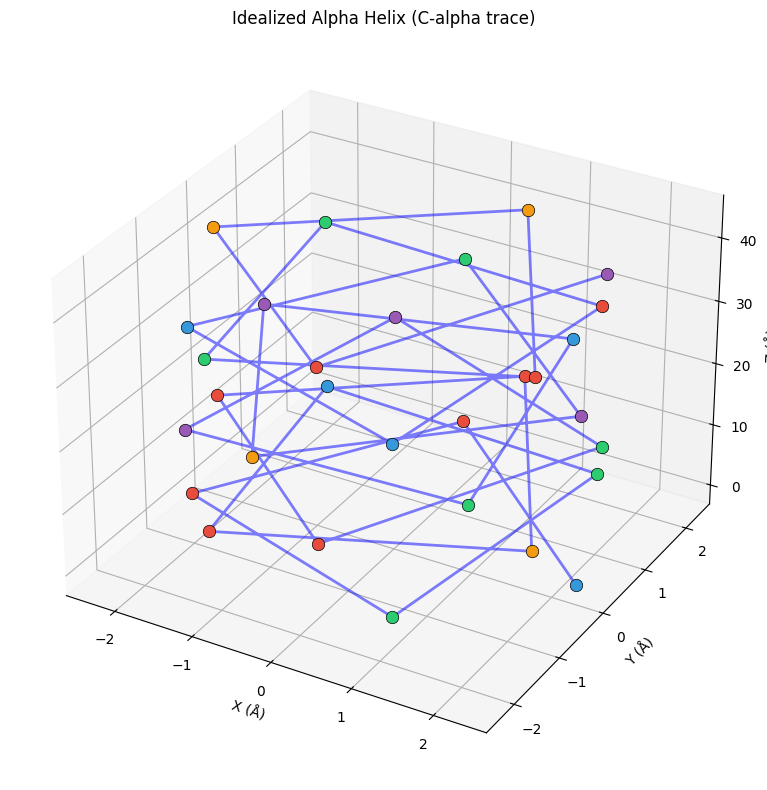

In [2]:
# Generate an idealized alpha helix
# Alpha helix parameters: 3.6 residues per turn, 1.5 A rise per residue
# Radius: 2.3 A

n_residues = 30
residues_per_turn = 3.6
rise_per_residue = 1.5  # Angstroms
radius = 2.3  # Angstroms

# Backbone atom coordinates (simplified: one atom per residue = C-alpha)
angles = np.array([2 * np.pi * i / residues_per_turn for i in range(n_residues)])
x = radius * np.cos(angles)
y = radius * np.sin(angles)
z = np.array([rise_per_residue * i for i in range(n_residues)])

# Amino acid sequence (random realistic)
aa_sequence = "AKELIAEFKRELSQVATYNL" + "AAELIKYFEQ"
assert len(aa_sequence) == n_residues

print(f"Alpha helix: {n_residues} residues")
print(f"Sequence: {aa_sequence}")
print(f"Height: {z[-1]:.1f} \u00c5")
print(f"Turns: {n_residues / residues_per_turn:.1f}")

# 3D visualization
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Draw backbone
ax.plot(x, y, z, 'b-', linewidth=2, alpha=0.5)

# Color by residue type
colors_aa = {'A': '#3498db', 'K': '#e74c3c', 'E': '#e74c3c', 'L': '#2ecc71',
             'I': '#2ecc71', 'F': '#f39c12', 'R': '#e74c3c', 'S': '#9b59b6',
             'Q': '#9b59b6', 'V': '#2ecc71', 'T': '#9b59b6', 'Y': '#f39c12',
             'N': '#9b59b6', 'D': '#e74c3c'}

for i in range(n_residues):
    color = colors_aa.get(aa_sequence[i], 'gray')
    ax.scatter(x[i], y[i], z[i], c=color, s=80, edgecolors='black', linewidth=0.5)

ax.set_xlabel('X (\u00c5)')
ax.set_ylabel('Y (\u00c5)')
ax.set_zlabel('Z (\u00c5)')
ax.set_title('Idealized Alpha Helix (C-alpha trace)')
plt.tight_layout()
plt.show()

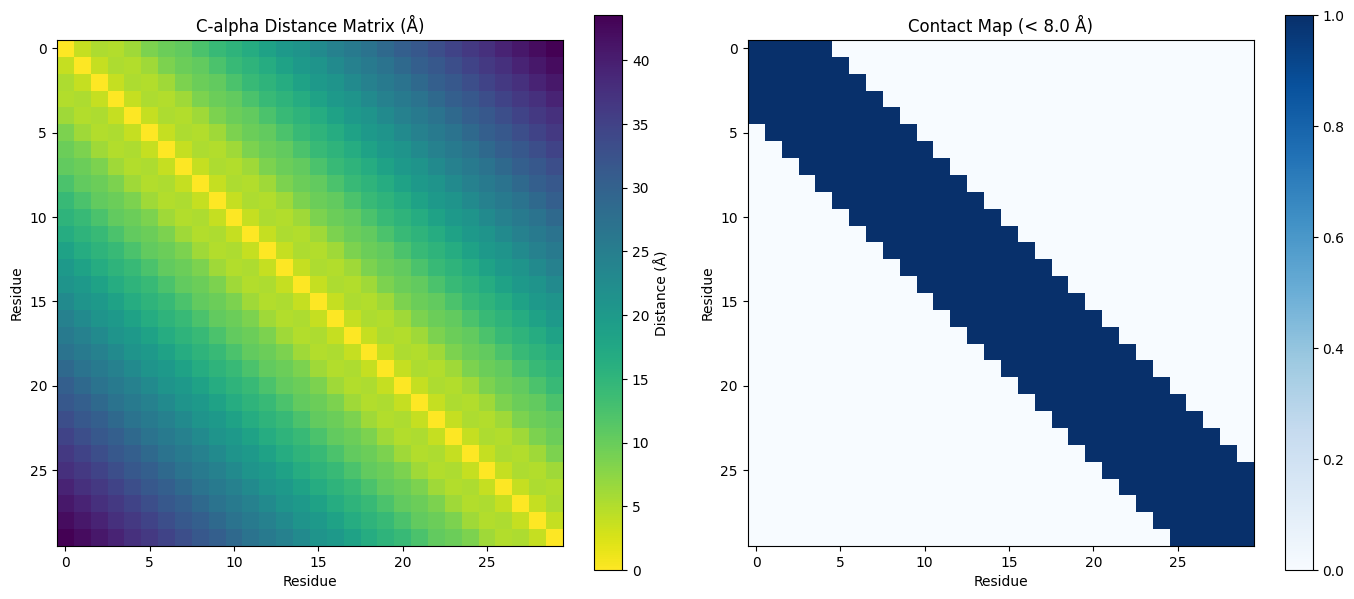

Total contacts: 125
Contact density: 28.74%


In [3]:
# Compute contact map (C-alpha distance matrix)
coords = np.column_stack([x, y, z])
distances = squareform(pdist(coords))

# Contact threshold: 8 A (standard for C-alpha contacts)
contact_threshold = 8.0
contacts = distances < contact_threshold

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Distance matrix
im1 = ax1.imshow(distances, cmap='viridis_r', interpolation='nearest')
ax1.set_xlabel('Residue')
ax1.set_ylabel('Residue')
ax1.set_title('C-alpha Distance Matrix (\u00c5)')
plt.colorbar(im1, ax=ax1, label='Distance (\u00c5)')

# Contact map
im2 = ax2.imshow(contacts.astype(int), cmap='Blues', interpolation='nearest')
ax2.set_xlabel('Residue')
ax2.set_ylabel('Residue')
ax2.set_title(f'Contact Map (< {contact_threshold} \u00c5)')
plt.colorbar(im2, ax=ax2)

plt.tight_layout()
plt.show()

n_contacts = contacts.sum() // 2  # Symmetric, so divide by 2
print(f"Total contacts: {n_contacts}")
print(f"Contact density: {n_contacts / (n_residues * (n_residues-1) / 2):.2%}")

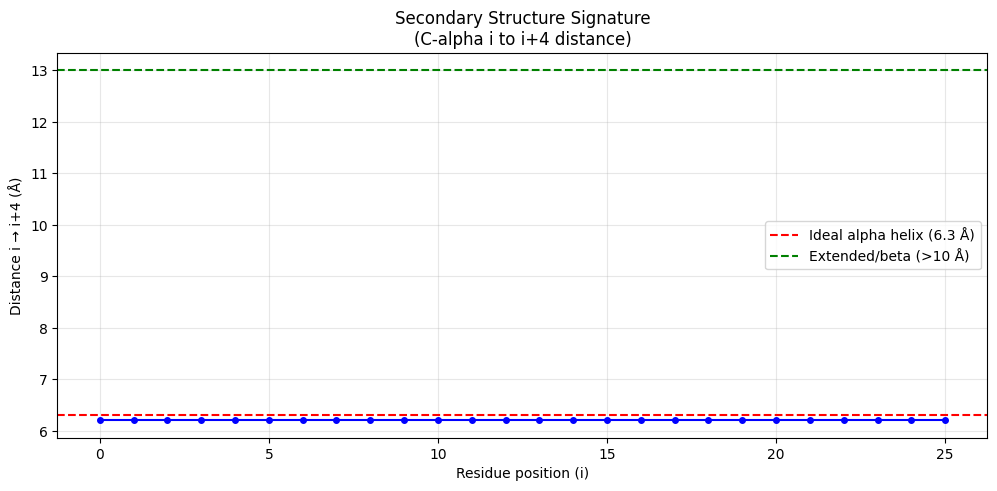

Mean i→i+4 distance: 6.2 Å
Expected for alpha helix: ~6.3 Å
All residues are in alpha helical conformation (as expected)


In [4]:
# Simplified secondary structure from C-alpha distances
# Alpha helix: i to i+4 distance ~6.3 A
# Beta sheet: i to i+2 distance ~6.7 A (extended)

helix_distances = []
for i in range(len(coords) - 4):
    d = np.linalg.norm(coords[i] - coords[i+4])
    helix_distances.append(d)

plt.figure(figsize=(12, 5))
plt.plot(range(len(helix_distances)), helix_distances, 'bo-', markersize=4)
plt.axhline(y=6.3, color='red', linestyle='--', label='Ideal alpha helix (6.3 \u00c5)')
plt.axhline(y=13.0, color='green', linestyle='--', label='Extended/beta (>10 \u00c5)')
plt.xlabel('Residue position (i)')
plt.ylabel('Distance i \u2192 i+4 (\u00c5)')
plt.title('Secondary Structure Signature\n(C-alpha i to i+4 distance)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"Mean i\u2192i+4 distance: {np.mean(helix_distances):.1f} \u00c5")
print(f"Expected for alpha helix: ~6.3 \u00c5")
print("All residues are in alpha helical conformation (as expected)")

## Section 2: Ramachandran Plot

The Ramachandran plot shows the backbone torsion angles (phi, psi) of each residue.
Different secondary structures occupy distinct regions:
- Alpha helix: $\phi \approx -60°, \psi \approx -45°$
- Beta sheet: $\phi \approx -120°, \psi \approx +130°$
- Left-handed helix: $\phi \approx +60°$ (rare, mainly glycine)

$$\phi = \text{C}_{i-1}\text{-N}_i\text{-C}_\alpha\text{-C}_i, \quad \psi = \text{N}_i\text{-C}_\alpha\text{-C}_i\text{-N}_{i+1}$$

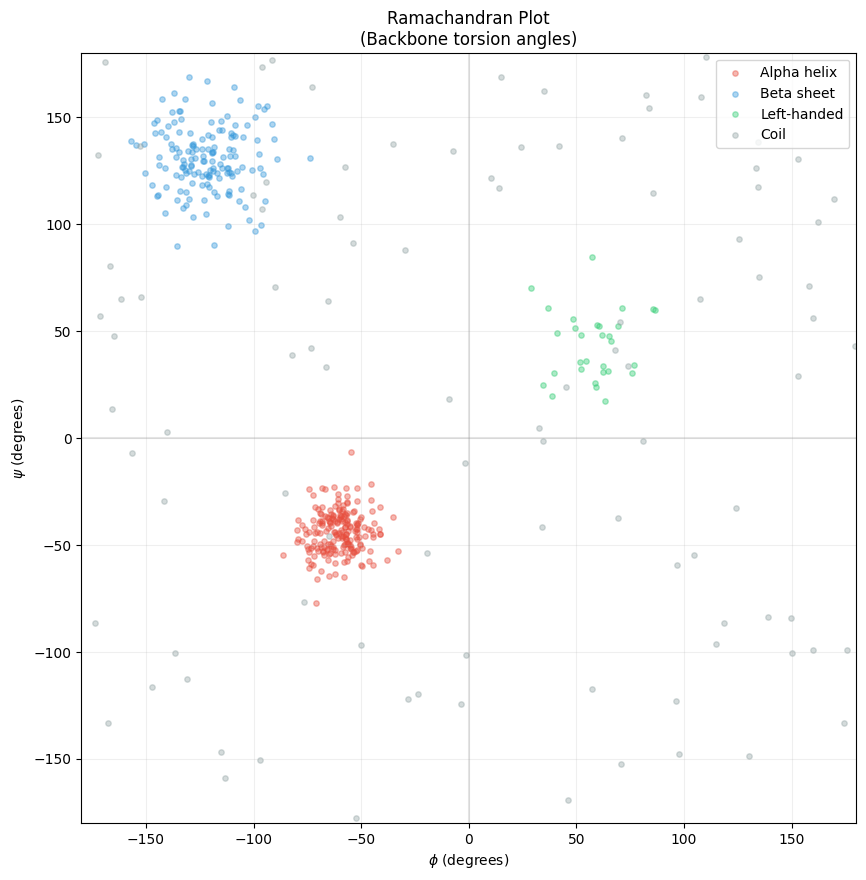

In [5]:
np.random.seed(42)

# Simulate phi/psi for different secondary structures
structures = {
    'Alpha helix': (np.random.normal(-60, 10, 200), np.random.normal(-45, 10, 200)),
    'Beta sheet': (np.random.normal(-120, 15, 150), np.random.normal(130, 15, 150)),
    'Left-handed': (np.random.normal(60, 15, 30), np.random.normal(45, 15, 30)),
    'Coil': (np.random.uniform(-180, 180, 100), np.random.uniform(-180, 180, 100)),
}

plt.figure(figsize=(10, 10))
colors_ss = {'Alpha helix': '#e74c3c', 'Beta sheet': '#3498db',
             'Left-handed': '#2ecc71', 'Coil': '#95a5a6'}

for name, (phi, psi) in structures.items():
    plt.scatter(phi, psi, alpha=0.4, s=15, label=name, color=colors_ss[name])

plt.xlim(-180, 180)
plt.ylim(-180, 180)
plt.xlabel(r'$\phi$ (degrees)')
plt.ylabel(r'$\psi$ (degrees)')
plt.title('Ramachandran Plot\n(Backbone torsion angles)')
plt.legend(fontsize=10)
plt.axhline(0, color='gray', linestyle='-', alpha=0.2)
plt.axvline(0, color='gray', linestyle='-', alpha=0.2)
plt.grid(True, alpha=0.2)
plt.show()

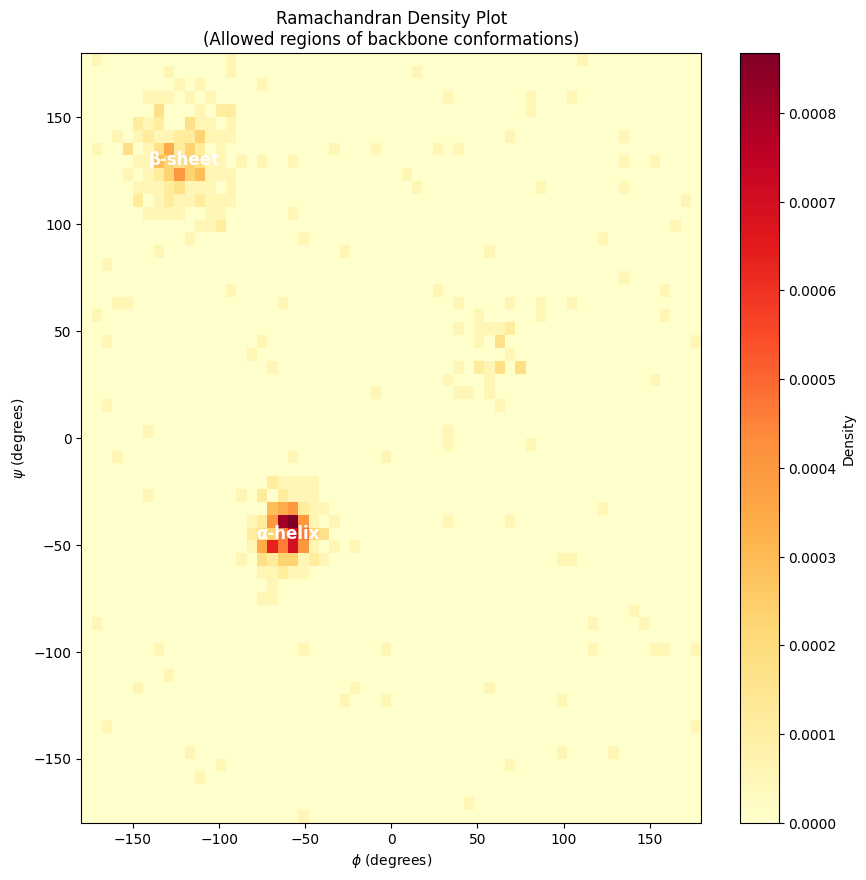

In [6]:
# Combine all phi/psi angles for density plot
all_phi = np.concatenate([s[0] for s in structures.values()])
all_psi = np.concatenate([s[1] for s in structures.values()])

fig, ax = plt.subplots(figsize=(10, 10))
h = ax.hist2d(all_phi, all_psi, bins=60, range=[[-180, 180], [-180, 180]],
              cmap='YlOrRd', density=True)
plt.colorbar(h[3], ax=ax, label='Density')
ax.set_xlabel(r'$\phi$ (degrees)')
ax.set_ylabel(r'$\psi$ (degrees)')
ax.set_title('Ramachandran Density Plot\n(Allowed regions of backbone conformations)')
ax.set_xlim(-180, 180)
ax.set_ylim(-180, 180)

# Label regions
ax.annotate('\u03b1-helix', xy=(-60, -45), fontsize=12, fontweight='bold', color='white',
           ha='center', va='center')
ax.annotate('\u03b2-sheet', xy=(-120, 130), fontsize=12, fontweight='bold', color='white',
           ha='center', va='center')
plt.show()

## Section 3: Drug-Likeness (Lipinski's Rule of Five)

Lipinski's Rule of Five predicts oral drug-likeness. A molecule is likely bioavailable if:
- Molecular weight \u2264 500 Da
- LogP \u2264 5 (lipophilicity)
- H-bond donors \u2264 5
- H-bond acceptors \u2264 10

Most approved oral drugs obey these rules. See [[Molecular Docking]] and
[[Dose-Response Relationship]].

In [7]:
# Define a set of drug molecules (name, SMILES notation)
drugs = {
    'Aspirin': 'CC(=O)Oc1ccccc1C(=O)O',
    'Ibuprofen': 'CC(C)Cc1ccc(cc1)C(C)C(=O)O',
    'Caffeine': 'Cn1c(=O)c2c(ncn2C)n(C)c1=O',
    'Metformin': 'CN(C)C(=N)NC(=N)N',
    'Penicillin V': 'CC1(C)SC2C(NC(=O)COc3ccccc3)C(=O)N2C1C(=O)O',
    'Paclitaxel': 'CC1=C2C(C(=O)C3(C(CC4C(C3C(C(C2(C)C(CC1OC(=O)C(C(c5ccccc5)NC(=O)c6ccccc6)O)O)OC(=O)C7CCCCC7)(CO4)OC(=O)C)OC(=O)C)O)C)OC(=O)C',
}

if HAS_RDKIT:
    print(f"{'Drug':<16} {'MW':>6} {'LogP':>6} {'HBD':>5} {'HBA':>5} {'Pass?':>7}")
    print("-" * 50)

    results = []
    for name, smiles in drugs.items():
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            mw = Descriptors.MolWt(mol)
            logp = Descriptors.MolLogP(mol)
            hbd = Descriptors.NumHDonors(mol)
            hba = Descriptors.NumHAcceptors(mol)
            passes = mw <= 500 and logp <= 5 and hbd <= 5 and hba <= 10
            results.append({'name': name, 'MW': mw, 'LogP': logp, 'HBD': hbd, 'HBA': hba, 'pass': passes})
            print(f"{name:<16} {mw:>6.1f} {logp:>6.2f} {hbd:>5} {hba:>5} {'YES' if passes else 'NO':>7}")
else:
    # Approximate properties from SMILES string analysis
    print("Using simplified Lipinski analysis (no RDKit)")
    print(f"{'Drug':<16} {'SMILES length':>14} {'Est. MW':>8}")
    print("-" * 42)
    for name, smiles in drugs.items():
        est_mw = len(smiles) * 8  # Very rough approximation
        print(f"{name:<16} {len(smiles):>14} {est_mw:>8}")

Using simplified Lipinski analysis (no RDKit)
Drug              SMILES length  Est. MW
------------------------------------------
Aspirin                      21      168
Ibuprofen                    26      208
Caffeine                     26      208
Metformin                    17      136
Penicillin V                 43      344
Paclitaxel                  124      992


In [8]:
if HAS_RDKIT:
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    names = [r['name'] for r in results]
    colors_lip = ['#2ecc71' if r['pass'] else '#e74c3c' for r in results]

    # MW
    axes[0,0].barh(names, [r['MW'] for r in results], color=colors_lip)
    axes[0,0].axvline(500, color='red', linestyle='--', label='Limit: 500')
    axes[0,0].set_xlabel('Molecular Weight (Da)')
    axes[0,0].set_title('Molecular Weight')
    axes[0,0].legend()

    # LogP
    axes[0,1].barh(names, [r['LogP'] for r in results], color=colors_lip)
    axes[0,1].axvline(5, color='red', linestyle='--', label='Limit: 5')
    axes[0,1].set_xlabel('LogP')
    axes[0,1].set_title('Lipophilicity (LogP)')
    axes[0,1].legend()

    # HBD
    axes[1,0].barh(names, [r['HBD'] for r in results], color=colors_lip)
    axes[1,0].axvline(5, color='red', linestyle='--', label='Limit: 5')
    axes[1,0].set_xlabel('H-bond Donors')
    axes[1,0].set_title('H-bond Donors')
    axes[1,0].legend()

    # HBA
    axes[1,1].barh(names, [r['HBA'] for r in results], color=colors_lip)
    axes[1,1].axvline(10, color='red', linestyle='--', label='Limit: 10')
    axes[1,1].set_xlabel('H-bond Acceptors')
    axes[1,1].set_title('H-bond Acceptors')
    axes[1,1].legend()

    plt.suptitle("Lipinski's Rule of Five Analysis\n(Green = passes, Red = violates)", fontsize=14)
    plt.tight_layout()
    plt.show()
else:
    print("Skipping visualization (RDKit not available)")

Skipping visualization (RDKit not available)


In [9]:
if HAS_RDKIT:
    fig, ax = plt.subplots(figsize=(10, 8))

    for r in results:
        color = '#2ecc71' if r['pass'] else '#e74c3c'
        ax.scatter(r['MW'], r['LogP'], s=200, c=color, edgecolors='black',
                  linewidth=1, zorder=5)
        ax.annotate(r['name'], (r['MW'], r['LogP']), fontsize=9,
                   xytext=(5, 5), textcoords='offset points')

    # Draw Lipinski boundaries
    ax.axvline(500, color='red', linestyle='--', alpha=0.5, label='MW limit')
    ax.axhline(5, color='blue', linestyle='--', alpha=0.5, label='LogP limit')

    # Shade the "drug-like" region
    ax.fill_between([0, 500], [-2, -2], [5, 5], alpha=0.1, color='green', label='Drug-like space')

    ax.set_xlabel('Molecular Weight (Da)')
    ax.set_ylabel('LogP (Lipophilicity)')
    ax.set_title('Drug-Likeness Space\n(Lower-left quadrant = oral drug candidates)')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_xlim(0, 900)
    ax.set_ylim(-2, 8)
    plt.tight_layout()
    plt.show()
else:
    print("Skipping (RDKit not available)")

Skipping (RDKit not available)


## Section 4: Molecular Fingerprints and Similarity

Molecular fingerprints encode chemical structure as bit vectors. Similar molecules
have similar fingerprints. The **Tanimoto coefficient** measures fingerprint similarity:

$$T(A, B) = \frac{|A \cap B|}{|A \cup B|} = \frac{c}{a + b - c}$$

where $a, b$ = number of bits set in A, B and $c$ = number of bits set in both.

This enables virtual screening: find molecules similar to a known drug.
See [[Functional Equivalence Classes]] -- structurally similar molecules may have
similar function.

In [10]:
if HAS_RDKIT:
    # Compute Morgan fingerprints (circular, radius 2)
    fps = {}
    for name, smiles in drugs.items():
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048)
            fps[name] = fp

    print(f"Morgan fingerprints computed for {len(fps)} molecules")
    print(f"Fingerprint length: 2048 bits")

    # Show bit density
    for name, fp in fps.items():
        bits_on = fp.GetNumOnBits()
        print(f"  {name}: {bits_on} bits on ({bits_on/2048:.1%})")
else:
    # Simplified fingerprint using SMILES character counts
    print("Using simplified SMILES-based fingerprints (no RDKit)")
    fps = {}
    for name, smiles in drugs.items():
        fp = np.zeros(128)
        for i, c in enumerate(smiles[:128]):
            fp[i] = ord(c) / 127
        fps[name] = fp

Using simplified SMILES-based fingerprints (no RDKit)


In [11]:
if HAS_RDKIT:
    # Compute pairwise Tanimoto similarity
    drug_names = list(fps.keys())
    n = len(drug_names)
    sim_matrix = np.zeros((n, n))

    for i in range(n):
        for j in range(n):
            sim_matrix[i, j] = DataStructs.TanimotoSimilarity(fps[drug_names[i]], fps[drug_names[j]])

    plt.figure(figsize=(9, 8))
    plt.imshow(sim_matrix, cmap='YlOrRd', vmin=0, vmax=1)
    plt.colorbar(label='Tanimoto Similarity')
    plt.xticks(range(n), drug_names, rotation=45, ha='right')
    plt.yticks(range(n), drug_names)
    plt.title('Drug Similarity Matrix (Morgan Fingerprints)')

    for i in range(n):
        for j in range(n):
            plt.text(j, i, f'{sim_matrix[i,j]:.2f}', ha='center', va='center', fontsize=8)

    plt.tight_layout()
    plt.show()

    # Most similar pair (excluding self)
    np.fill_diagonal(sim_matrix, 0)
    max_idx = np.unravel_index(sim_matrix.argmax(), sim_matrix.shape)
    print(f"Most similar pair: {drug_names[max_idx[0]]} & {drug_names[max_idx[1]]} (T = {sim_matrix[max_idx]:.3f})")
else:
    print("Skipping similarity matrix (RDKit not available)")

Skipping similarity matrix (RDKit not available)


In [12]:
if HAS_RDKIT:
    # Generate a larger set of molecules for chemical space visualization
    from rdkit.Chem import rdMolDescriptors

    # Use the drugs we have + additional common drugs
    all_smiles = {
        'Aspirin': 'CC(=O)Oc1ccccc1C(=O)O',
        'Ibuprofen': 'CC(C)Cc1ccc(cc1)C(C)C(=O)O',
        'Caffeine': 'Cn1c(=O)c2c(ncn2C)n(C)c1=O',
        'Metformin': 'CN(C)C(=N)NC(=N)N',
        'Acetaminophen': 'CC(=O)Nc1ccc(O)cc1',
        'Naproxen': 'COc1ccc2cc(CC(C)C(=O)O)ccc2c1',
        'Diazepam': 'CN1C(=O)CN=C(c2ccccc2)c3cc(Cl)ccc13',
        'Omeprazole': 'COc1ccc2[nH]c(S(=O)Cc3ncc(C)c(OC)c3C)nc2c1',
    }

    fp_array = []
    names_all = []
    for name, smiles in all_smiles.items():
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048)
            arr = np.zeros(2048)
            DataStructs.ConvertToNumpyArray(fp, arr)
            fp_array.append(arr)
            names_all.append(name)

    fp_matrix = np.array(fp_array)

    # Use PCA (t-SNE needs more points to be meaningful)
    from sklearn.decomposition import PCA
    pca = PCA(n_components=2)
    coords_2d = pca.fit_transform(fp_matrix)

    plt.figure(figsize=(10, 8))
    plt.scatter(coords_2d[:, 0], coords_2d[:, 1], s=200, c='steelblue', edgecolors='black')
    for i, name in enumerate(names_all):
        plt.annotate(name, (coords_2d[i, 0], coords_2d[i, 1]), fontsize=9,
                    xytext=(8, 8), textcoords='offset points')
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
    plt.title('Chemical Space (PCA of Morgan Fingerprints)')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("Skipping chemical space visualization (RDKit not available)")

Skipping chemical space visualization (RDKit not available)


## Section 5: Binding Site Analysis

Drug design targets specific protein binding sites. A binding site is a cavity on the
protein surface where small molecules can bind and modulate function.
See [[Molecular Docking]] -- computational docking predicts binding poses and affinities.

Key binding site features:
- **Volume**: must accommodate the drug molecule
- **Hydrophobicity**: drives non-polar drug binding
- **Charge complementarity**: matches drug charge distribution

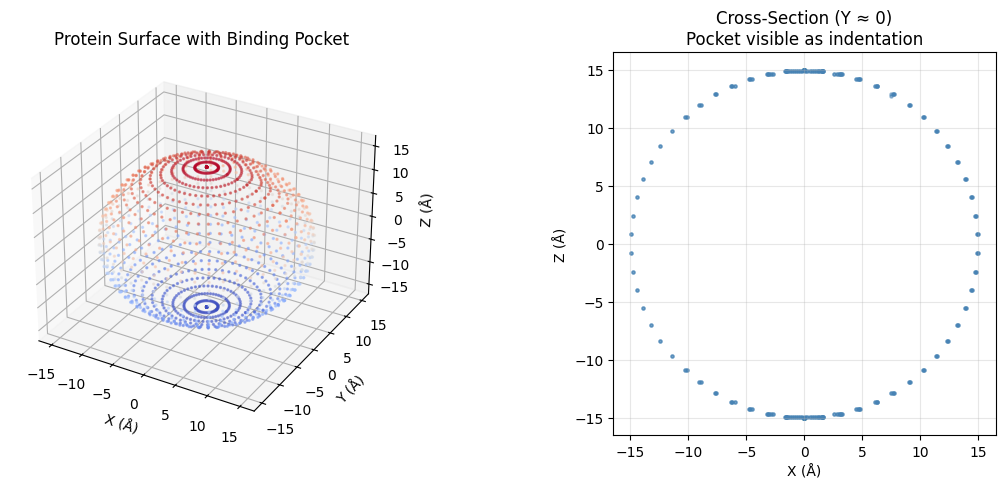

In [13]:
# Create a simplified binding pocket from protein coordinates
# Real analysis uses tools like fpocket, SiteMap, or P2Rank

# Generate a protein surface with a pocket
np.random.seed(42)
theta = np.linspace(0, 2*np.pi, 50)
phi_angles = np.linspace(0, np.pi, 30)

# Protein as a sphere with a pocket
surface_x = []
surface_y = []
surface_z = []

for t in theta:
    for p in phi_angles:
        r = 15  # Base radius
        # Create a pocket (depression) at a specific location
        pocket_center = np.array([0.5, 0.5, 0.8])
        point_dir = np.array([np.sin(p)*np.cos(t), np.sin(p)*np.sin(t), np.cos(p)])
        dist_to_pocket = np.linalg.norm(point_dir - pocket_center)
        if dist_to_pocket < 0.4:
            r -= 4 * (0.4 - dist_to_pocket)  # Indent

        surface_x.append(r * np.sin(p) * np.cos(t))
        surface_y.append(r * np.sin(p) * np.sin(t))
        surface_z.append(r * np.cos(p))

fig = plt.figure(figsize=(12, 5))

# Surface view
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(surface_x, surface_y, surface_z, c=surface_z, cmap='coolwarm', s=2, alpha=0.5)
ax1.set_title('Protein Surface with Binding Pocket')
ax1.set_xlabel('X (\u00c5)')
ax1.set_ylabel('Y (\u00c5)')
ax1.set_zlabel('Z (\u00c5)')

# Cross-section
ax2 = fig.add_subplot(122)
# Take a slice through the pocket
slice_mask = [abs(y) < 2 for y in surface_y]
sx = [surface_x[i] for i in range(len(surface_x)) if slice_mask[i]]
sz = [surface_z[i] for i in range(len(surface_z)) if slice_mask[i]]
ax2.scatter(sx, sz, s=5, alpha=0.5, color='steelblue')
ax2.set_xlabel('X (\u00c5)')
ax2.set_ylabel('Z (\u00c5)')
ax2.set_title('Cross-Section (Y \u2248 0)\nPocket visible as indentation')
ax2.set_aspect('equal')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

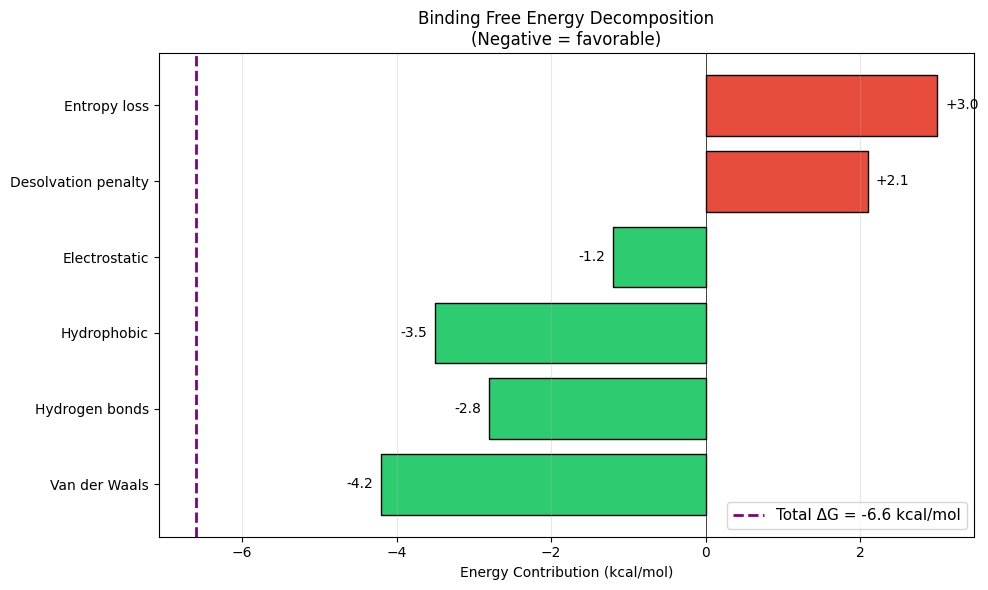

Predicted binding free energy: -6.6 kcal/mol
Favorable binding
Approximate Kd: 1.47e-05 M


In [14]:
# Simplified binding energy calculation
# In reality, this requires molecular mechanics or quantum methods

# Factors contributing to binding free energy
contributions = {
    'Van der Waals': -4.2,
    'Hydrogen bonds': -2.8,
    'Hydrophobic': -3.5,
    'Electrostatic': -1.2,
    'Desolvation penalty': +2.1,
    'Entropy loss': +3.0,
}

total = sum(contributions.values())

fig, ax = plt.subplots(figsize=(10, 6))
names_be = list(contributions.keys())
values_be = list(contributions.values())
colors_be = ['#2ecc71' if v < 0 else '#e74c3c' for v in values_be]

bars = ax.barh(names_be, values_be, color=colors_be, edgecolor='black')
ax.axvline(0, color='black', linewidth=0.5)
ax.axvline(total, color='purple', linestyle='--', linewidth=2, label=f'Total \u0394G = {total:.1f} kcal/mol')
ax.set_xlabel('Energy Contribution (kcal/mol)')
ax.set_title('Binding Free Energy Decomposition\n(Negative = favorable)')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, axis='x')

for bar, val in zip(bars, values_be):
    ax.text(val + (0.1 if val >= 0 else -0.1), bar.get_y() + bar.get_height()/2,
            f'{val:+.1f}', ha='left' if val >= 0 else 'right', va='center', fontsize=10)

plt.tight_layout()
plt.show()

print(f"Predicted binding free energy: {total:.1f} kcal/mol")
print(f"{'Favorable' if total < 0 else 'Unfavorable'} binding")
print(f"Approximate Kd: {np.exp(total / (0.593)):.2e} M")  # RT at 298K

## Section 6: Virtual Screening Pipeline Overview

Virtual screening searches millions of molecules to find potential drug candidates.
The computational pipeline:

1. **Target preparation**: protein structure + binding site
2. **Library filtering**: Lipinski, PAINS, reactive groups \u2192 reject bad molecules
3. **Docking**: score each molecule in the binding site \u2192 ranked list
4. **Rescoring**: more accurate scoring (MM-PBSA, FEP)
5. **Hit selection**: top candidates for experimental testing

See [[Diffusion-Based Protein Design]] and [[Prediction-to-Generation Paradigm Shift]].

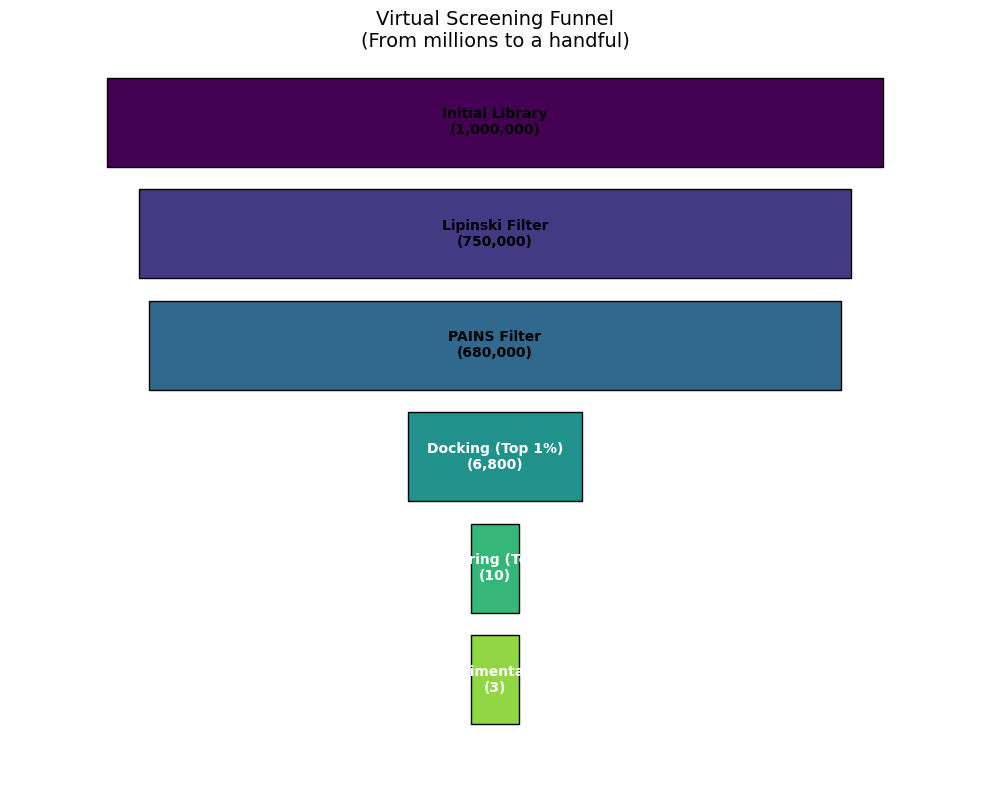

Key insight: computational filtering reduces experimental work by 5-6 orders of magnitude
Cost: ~$0.001/molecule (compute) vs ~$1000/molecule (experiment)


In [15]:
# Virtual screening funnel visualization
stages = ['Initial Library', 'Lipinski Filter', 'PAINS Filter',
          'Docking (Top 1%)', 'Rescoring (Top 10)', 'Experimental Hits']
counts_vs = [1000000, 750000, 680000, 6800, 10, 3]

fig, ax = plt.subplots(figsize=(10, 8))

max_width = 0.8
for i, (stage, count) in enumerate(zip(stages, counts_vs)):
    width = max_width * (count / counts_vs[0]) ** 0.3  # Logarithmic scaling for visibility
    width = max(width, 0.05)  # Minimum width

    color = plt.cm.viridis(i / len(stages))
    rect = plt.Rectangle(((1-width)/2, len(stages)-1-i), width, 0.8,
                         facecolor=color, edgecolor='black', linewidth=1)
    ax.add_patch(rect)

    ax.text(0.5, len(stages)-1-i+0.4, f'{stage}\n({count:,})',
           ha='center', va='center', fontsize=10, fontweight='bold',
           color='white' if i > 2 else 'black')

ax.set_xlim(0, 1)
ax.set_ylim(-0.5, len(stages))
ax.set_title('Virtual Screening Funnel\n(From millions to a handful)', fontsize=14)
ax.axis('off')
plt.tight_layout()
plt.show()

print("Key insight: computational filtering reduces experimental work by 5-6 orders of magnitude")
print("Cost: ~$0.001/molecule (compute) vs ~$1000/molecule (experiment)")

## Summary

| Concept | What you built | Why it matters |
|---------|---------------|----------------|
| Protein structure | Alpha helix coordinates | [[Protein Structure Prediction]] foundation |
| Contact maps | C-alpha distance matrix | Fold topology representation |
| Ramachandran | Phi/psi angle plot | Structure validation |
| Lipinski rules | Drug-likeness filter | [[Dose-Response Relationship]] prerequisite |
| Fingerprints | Morgan circular FP | Chemical similarity search |
| Tanimoto | Pairwise similarity | [[Functional Equivalence Classes]] in chemistry |
| Virtual screening | Computational funnel | Drug discovery pipeline |

**The complete series:**
- [[01_Sequence_Analysis_Fundamentals]] -- Biopython, the Central Dogma
- [[02_Genomic_Variant_Analysis]] -- Population genetics, GWAS
- [[03_Single_Cell_Transcriptomics]] -- scanpy, cell type discovery
- [[04_Protein_Structure_Drug_Discovery]] -- Structure and drug design (this notebook)